In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [70]:
file = Path('Task 3 and 4_Loan_Data.csv')
df = pd.read_csv(file)
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [71]:
#Let engenieer some features 
df.columns = ['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
             'total_debt_outstanding','income','years_employed','fico_score','default']
# Debt-to-Income Ratio 
df['debt_to_income'] = df['total_debt_outstanding'] / df['income']
# Interpretation: If DTI > 0.43, very risky (standard threshold)

# Loan-to-Income Ratio
df['loan_to_income'] = df['loan_amt_outstanding'] / df['income']

# Credit Card Debt 
df['credit_card_debt'] = df['total_debt_outstanding'] - df['loan_amt_outstanding']

# Average Debt per Credit Line
df['avg_debt_per_line'] = df['total_debt_outstanding'] / (df['credit_lines_outstanding'] + 1) # +1 to avoid division by zero


# FICO Score Categories will help XGBoost learn threasholds
df['fico_category'] = pd.cut(df['fico_score'], 
                              bins=[0, 579, 669, 739, 799, 850],
                              labels=['Very Poor', 'Fair', 'Good', 'Very Good', 'Exceptional'])

# Employment Stability Flag (usualy researches consider the threshold to be between 3-5 years which depends case by case)
df['stable_employment'] = (df['years_employed'] >= 3).astype(int)

# 7. High Debt Flag (High DTI considered to be >43%)
df['high_debt_burden'] = (df['debt_to_income'] > 0.43).astype(int)

# 8. Income Bracket (depends on the country but as it is a simulation the best estimate would be relative to the data set)
df['income_bracket'] = pd.qcut(df['income'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


In [72]:
df = pd.get_dummies(df, columns = ['fico_category','income_bracket'])
df.shape

(10000, 23)

In [73]:
df.columns

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default', 'debt_to_income', 'loan_to_income', 'credit_card_debt',
       'avg_debt_per_line', 'stable_employment', 'high_debt_burden',
       'fico_category_Very Poor', 'fico_category_Fair', 'fico_category_Good',
       'fico_category_Very Good', 'fico_category_Exceptional',
       'income_bracket_Low', 'income_bracket_Medium', 'income_bracket_High',
       'income_bracket_Very High'],
      dtype='object')

In [74]:
from sklearn.model_selection import train_test_split
X = df.drop(columns = ['customer_id','default'])
Y = df['default']

# Split only into train and test (no val as the DS is small and we will use CV)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [80]:
from sklearn.model_selection import GridSearchCV

#searchgin for best parameters
param_grid = {
    'n_estimators': [100, 200],  
    'max_depth': [4, 6, 8],     
    'learning_rate': [0.05, 0.1], 
    'subsample': [0.8, 1.0],     
    'colsample_bytree': [0.8, 1.0], 
    'min_child_weight': [1],  
} #AUC = 0.9998391643176918, {'colsample_bytree': 0.8,'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4,'min_child_weight': 1,'n_estimators': 100,'subsample': 0.8}

param_grid_lr_test = {
    'learning_rate': [0.01, 0.02, 0.03],
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [3, 4],              # Keep shallow based on your results
    'subsample': [0.8],               # Fix at your optimal
    'colsample_bytree': [0.8],        # Fix at your optimal
    'min_child_weight': [1],          # Fix at your optimal
    'gamma': [0]                       # Fix at your optimal
} #AUC = 0.9990913612999502

#would try this as well to find the BEST params but it would take 3-5 business days for my laptop to compute
param_grid_refined = {
    'n_estimators': [50, 100, 150, 200],      
    'max_depth': [2, 3, 4, 5],                 
    'learning_rate': [0.01, 0.03, 0.05, 0.08], 
    'subsample': [0.7, 0.8, 0.9],              
    'colsample_bytree': [0.7, 0.8, 0.9],     
    'min_child_weight': [1, 3, 5],             
    'gamma': [0, 0.05, 0.1]                    
}

final_params = {'n_estimators': [100],      
    'max_depth': [4],                 
    'learning_rate': [0.05], 
    'subsample': [0.8],              
    'colsample_bytree': [0.8],     
    'min_child_weight': [1],             
    'gamma': [0]                    
}


# Calculate class weights for imbalanced data
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])


In [81]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize model
xgb = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight, eval_metric='logloss')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=final_params, scoring='roc_auc', cv=cv,
    n_jobs=-1, 
    verbose=2,
    return_train_score=True)


In [83]:
grid_search.fit(X_train, y_train)

In [97]:
params = grid_search.best_params_

best_model = grid_search.best_estimator_

default_probabilities = grid_search.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, default_probabilities)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"Test AUC: {test_auc}")
print('='*70)
print(f"Importance of the features: {feature_importance.to_string(index=False)}")

Test AUC: 0.9998391643176918
Importance of the features:                   Feature  Importance
           debt_to_income    0.453661
 credit_lines_outstanding    0.328927
         credit_card_debt    0.042987
       income_bracket_Low    0.038068
           years_employed    0.020835
        stable_employment    0.018806
   total_debt_outstanding    0.017735
  fico_category_Very Poor    0.015601
               fico_score    0.011211
                   income    0.009861
        avg_debt_per_line    0.009492
           loan_to_income    0.006757
       fico_category_Fair    0.006272
       fico_category_Good    0.006137
     loan_amt_outstanding    0.005988
    income_bracket_Medium    0.003681
      income_bracket_High    0.002078
  fico_category_Very Good    0.001904
         high_debt_burden    0.000000
fico_category_Exceptional    0.000000
 income_bracket_Very High    0.000000


Please enter the loan amount for the portfolio: 10000



Portfolio Metrics (assuming $10,000.0 loans):
  Number of Loans: 2,000
  Total Exposure: $20,000,000.00
  Total Expected Loss: $3,472,561.00
  Average Expected Loss per Loan: $1,736.28
  Portfolio Loss Rate: 17.36%

RISK SEGMENTATION
                Count  Avg PD  Total Expected Loss  Actual Defaults
Risk_Category                                                      
Low Risk         1578  0.0050         7.068653e+04                0
Medium Risk        33  0.1875         5.569594e+04                3
High Risk          11  0.3858         3.819654e+04                0
Very High Risk    378  0.9724         3.307982e+06              367


/var/folders/m7/3b38xcb97vq1rhp8j68wynn80000gn/T/ipykernel_75816/1186231141.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = risk_segments.groupby('Risk_Category').agg({


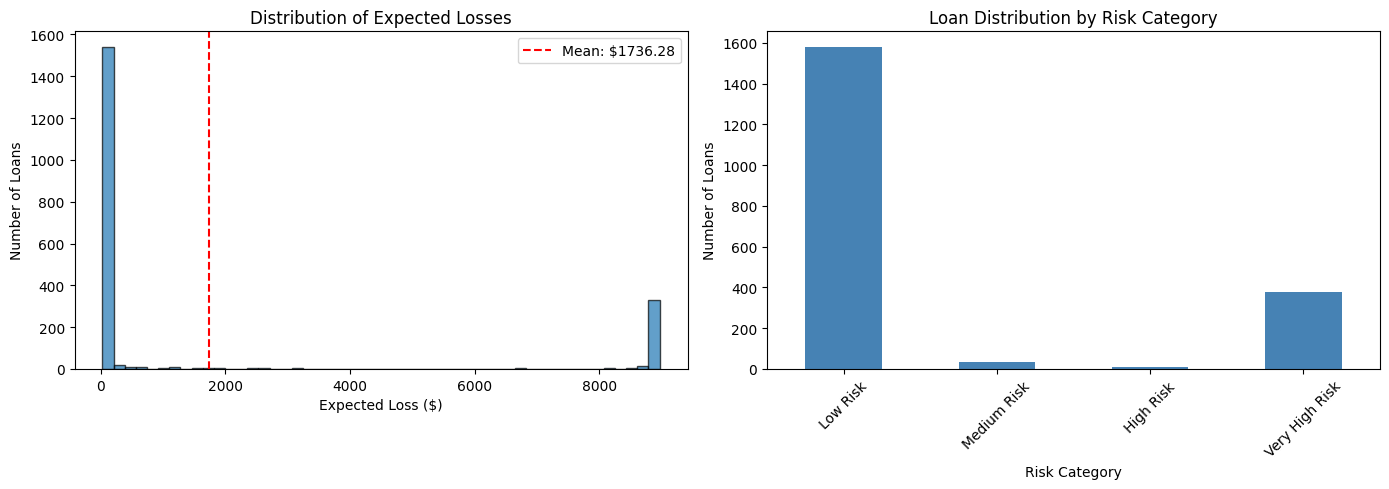

In [99]:
#Portfolio Analysis
import matplotlib.pyplot as plt
#Calculating the expected loss
test_probabilities = best_model.predict_proba(X_test)[:, 1]
loan_amount = float(input('Please enter the loan amount for the portfolio:'))
recovery_rate = 0.10

# Calculate expected loss for each loan
expected_losses = loan_amount * test_probabilities * (1 - recovery_rate)

# Portfolio metrics
total_exposure = loan_amount * len(X_test)
total_expected_loss = expected_losses.sum()
avg_expected_loss = expected_losses.mean()
portfolio_loss_rate = total_expected_loss / total_exposure

print(f"\nPortfolio Metrics (assuming ${loan_amount:,} loans):")
print(f"  Number of Loans: {len(X_test):,}")
print(f"  Total Exposure: ${total_exposure:,.2f}")
print(f"  Total Expected Loss: ${total_expected_loss:,.2f}")
print(f"  Average Expected Loss per Loan: ${avg_expected_loss:,.2f}")
print(f"  Portfolio Loss Rate: {portfolio_loss_rate:.2%}")

# Risk segmentation
risk_segments = pd.DataFrame({'Probability_of_Default': test_probabilities,'Expected_Loss': expected_losses,
    'Actual_Default': y_test.values})

risk_segments['Risk_Category'] = pd.cut(risk_segments['Probability_of_Default'],bins=[0, 0.1, 0.3, 0.5, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
)

print("\n" + "="*70)
print("RISK SEGMENTATION")
print("="*70)

segment_summary = risk_segments.groupby('Risk_Category').agg({
    'Probability_of_Default': ['count', 'mean'],
    'Expected_Loss': 'sum',
    'Actual_Default': 'sum'
}).round(4)

segment_summary.columns = ['Count', 'Avg PD', 'Total Expected Loss', 'Actual Defaults']
print(segment_summary)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of expected losses
axes[0].hist(expected_losses, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Expected Loss ($)')
axes[0].set_ylabel('Number of Loans')
axes[0].set_title('Distribution of Expected Losses')
axes[0].axvline(avg_expected_loss, color='red', linestyle='--',label=f'Mean: ${avg_expected_loss:.2f}')
axes[0].legend()

# Risk categories
segment_summary['Count'].plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_xlabel('Risk Category')
axes[1].set_ylabel('Number of Loans')
axes[1].set_title('Loan Distribution by Risk Category')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()